In [1]:
from pycocotools.coco import COCO 
from PIL import Image 
import numpy as np 
import skimage.io as io 
import matplotlib.pyplot as plt 
import pylab 
import json 
import os 
import random 
import math 
import seaborn as sns 
from tqdm import tqdm 
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.text import * 
from tensorflow.keras.preprocessing.sequence import * 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2 # apt-get install libgl1-mesa-glx

np.random.seed(2021) # for reproducibility 

# Data preprocessing

In [2]:
with open('v2_mscoco_val2014_annotations.json') as json_file:  
    ans = json.load(json_file) 
    
with open('v2_OpenEnded_mscoco_val2014_questions.json') as json_file: 
    questions = json.load(json_file)

In [3]:
image_dir = os.listdir('val2014/val2014/') 
len(image_dir)

40504

In [4]:
index = np.random.choice(len(image_dir), int(0.5 * len(image_dir)), replace = False) 

In [5]:
image_dir = np.asarray(image_dir) 
image_dir = image_dir[index] 
image_dir.shape

(20252,)

In [6]:
image_ids = []
for i in range(len(image_dir)): 
    int_id = int(image_dir[i][14:25]) 
    image_ids.append(int_id) 
    
image_ids = np.asarray(image_ids) 
image_ids

array([447038, 262360, 251717, ...,  11122, 290896, 271576])

In [7]:
arr1 = [] # contains (image_id, question_id, question)
question_ids = [] 
for i in tqdm(range(len(questions['questions'])), position = 0, leave = True): 
    if questions['questions'][i]['image_id'] in image_ids: 
        arr1.append((questions['questions'][i]['image_id'],
                     questions['questions'][i]['question_id'], 
                     questions['questions'][i]['question']))      
        question_ids.append(questions['questions'][i]['question_id'])


100%|██████████| 214354/214354 [00:03<00:00, 63931.17it/s]


In [8]:
arr2 = [] # contains (question_id, answer) 

for i in tqdm(range(len(ans['annotations'])), position = 0, leave = True): 
    if ans['annotations'][i]['question_id'] in question_ids:   
        arr2.append((ans['annotations'][i]['question_id'], 
                     ans['annotations'][i]['multiple_choice_answer']))


100%|██████████| 214354/214354 [02:54<00:00, 1230.91it/s]


In [9]:
print(len(arr1), len(arr2)) 

106733 106733


In [10]:
arr = [] # contains (image_id, question, answer) 

# merge information from arr1 and arr2 
for i in tqdm(range(len(arr2)), position = 0, leave = True): 
    for j in range(len(arr1)): 
        if arr2[i][0] == arr1[j][1]: # if the question ids match 
            arr.append((arr1[j][0], arr1[j][2], arr2[i][1])) # append (image_id, question, answer)


100%|██████████| 106733/106733 [29:45<00:00, 59.79it/s]


In [11]:
print(len(arr)) 

106733


In [12]:
# get actual images for training from the triplet data 
X_images = [] 
X_questions = [] 
Y_answers = [] 

for i in tqdm(range(len(arr))): 
    image_id = arr[i][0] 
    question = arr[i][1] 
    answer = arr[i][2] 
    # obtain actual image from the image id 
    image_id_str = str(image_id) 
    while len(image_id_str) < 12: # prepend zero to make the length of the id 12 
        image_id_str = '0' + image_id_str  
    dirname = 'val2014/val2014/COCO_val2014_' + image_id_str + '.jpg' 
    image = Image.open(dirname).convert('RGB') 
    image = image.resize((448,448)) # sacle to 448x448 for this example 
    image = np.asarray(image) 
    assert image.ndim == 3 
    X_images.append(image) 
    X_questions.append(question) 
    Y_answers.append(answer)


100%|██████████| 106733/106733 [18:39<00:00, 95.35it/s] 


In [16]:
X_images = np.asarray(X_images)
X_questions = np.asarray(X_questions) 
Y_answers = np.asarray(Y_answers)

In [17]:
X_images.shape, X_questions.shape, Y_answers.shape

((106733, 448, 448, 3), (106733,), (106733,))

# Extracting Image Features 

In [29]:
X_images_extracted = [] 
def VGG19_Top(): 
    model = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet', input_shape = (448,448,3))
    input_layer = model.input 
    hidden_layer = model.layers[-1].output 
    model = Model(input_layer, hidden_layer) 
    return model 

def EfficientNet_Top(): 
    model = tf.keras.applications.EfficientNetB7(include_top = False, weights = 'imagenet', input_shape = (448,448,3))
    input_layer = model.input 
    hidden_layer = model.layers[-1].output 
    model = Model(input_layer, hidden_layer) 
    return model 

def generateImageFeatures(images): 
    model = VGG19_Top() 
    for i in tqdm(range(images.shape[0])): 
        features = model(images[i].reshape((1,448,448,3))) 
        X_images_extracted.append(features.numpy().reshape((196,512)))
        
        
generateImageFeatures(X_images) 




100%|██████████| 106733/106733 [21:57<00:00, 81.01it/s]


In [30]:
X_images_extracted = np.asarray(X_images_extracted) 
X_images_extracted.shape 

(106733, 196, 512)

# Create Question Vector

In [31]:
tokenizer_questions = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

tokenizer_questions.fit_on_texts(X_questions)

train_question_seqs = tokenizer_questions.texts_to_sequences(X_questions) 

question_vector = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding = 'post')


In [32]:
question_vector.shape

(106733, 23)

# Create Answer Vector

In [44]:
target_size = len(np.unique(Y_answers))
target_size

8926

In [33]:
label_encoder = LabelBinarizer() 
answer_vector = label_encoder.fit_transform(Y_answers)

answer_vector.shape

(106733, 8926)

In [34]:
print("splitting images and questions...")
train_images, val_images, train_questions, val_questions = train_test_split(X_images_extracted, 
                                                                            question_vector, 
                                                                            test_size = 0.1, 
                                                                            random_state = 2021)
print("splitting answers and questions...")
train_answers, val_answers, _, _ = train_test_split(answer_vector,
                                                    question_vector,
                                                    test_size = 0.1,
                                                    random_state = 2021)

print(train_images.shape, val_images.shape)

splitting images and questions...
splitting answers and questions...
(96059, 196, 512) (10674, 196, 512)


In [45]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = target_size
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(tokenizer_questions.word_index)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        # atten for image feature
        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat


In [46]:
def build_model():
    image_input = tf.keras.layers.Input(shape = (196, 512))

    question_input = tf.keras.layers.Input(shape=(question_vector.shape[1],))

    output = CoattentionModel()(image_input,question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [47]:
model = build_model() 
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 196, 512)]   0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
coattention_model_2 (Coattentio (None, 8926)         20298464    input_18[0][0]                   
                                                                 input_19[0][0]                   
Total params: 20,298,464
Trainable params: 20,298,464
Non-trainable params: 0
__________________________________________________________________________________________________


In [48]:
model_path = 'hicoattention_vqa_epoch_{epoch:03d}_val_{val_loss:.3f}_val_accuracy_{val_accuracy:.3f}.h5' 

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.6) 

checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True)

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10) 

history = model.fit([train_images, train_questions], 
                    train_answers, 
                    batch_size = 128, 
                    epochs = 50, 
                    validation_data = ([val_images, val_questions], val_answers), 
                    callbacks = [learning_rate_reduction, checkpoint]) 

Epoch 1/50
751/751 [==============================] - 126s 148ms/step - loss: 5.1367 - accuracy: 0.2069 - val_loss: 3.9816 - val_accuracy: 0.2567

Epoch 00001: val_accuracy improved from -inf to 0.25670, saving model to hicoattention_vqa_epoch_001_val_3.982_val_accuracy_0.257.h5
Epoch 2/50
751/751 [==============================] - 66s 88ms/step - loss: 3.8190 - accuracy: 0.2515 - val_loss: 3.7942 - val_accuracy: 0.2752

Epoch 00002: val_accuracy improved from 0.25670 to 0.27525, saving model to hicoattention_vqa_epoch_002_val_3.794_val_accuracy_0.275.h5
Epoch 3/50
751/751 [==============================] - 68s 90ms/step - loss: 3.5575 - accuracy: 0.2665 - val_loss: 3.7278 - val_accuracy: 0.2675

Epoch 00003: val_accuracy did not improve from 0.27525
Epoch 4/50
751/751 [==============================] - 68s 90ms/step - loss: 3.3948 - accuracy: 0.2711 - val_loss: 3.6745 - val_accuracy: 0.2863

Epoch 00004: val_accuracy improved from 0.27525 to 0.28630, saving model to hicoattention_vqa_

751/751 [==============================] - 101s 135ms/step - loss: 1.8457 - accuracy: 0.4266 - val_loss: 4.1054 - val_accuracy: 0.3376

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.6796157979115377e-06.

Epoch 00032: val_accuracy improved from 0.33755 to 0.33764, saving model to hicoattention_vqa_epoch_032_val_4.105_val_accuracy_0.338.h5
Epoch 33/50
751/751 [==============================] - 64s 85ms/step - loss: 1.8499 - accuracy: 0.4283 - val_loss: 4.1077 - val_accuracy: 0.3365

Epoch 00033: val_accuracy did not improve from 0.33764
Epoch 34/50
751/751 [==============================] - 67s 90ms/step - loss: 1.8518 - accuracy: 0.4265 - val_loss: 4.1093 - val_accuracy: 0.3366

Epoch 00034: val_accuracy did not improve from 0.33764
Epoch 35/50
751/751 [==============================] - 66s 88ms/step - loss: 1.8364 - accuracy: 0.4287 - val_loss: 4.1117 - val_accuracy: 0.3363

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0077694923893431e-06.

Epoch 00035: val

# Plot loss and accuracy graph

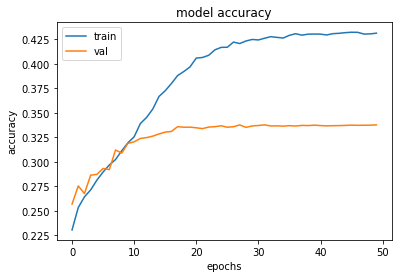

In [49]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epochs') 
plt.legend(['train', 'val'], loc = 'upper left') 
plt.show() 

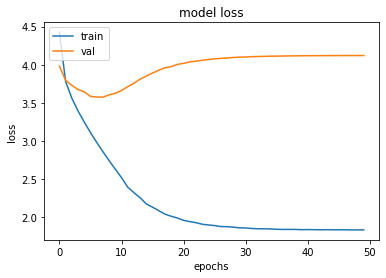

In [50]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epochs') 
plt.legend(['train','val'], loc = 'upper left') 
plt.show() 